In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

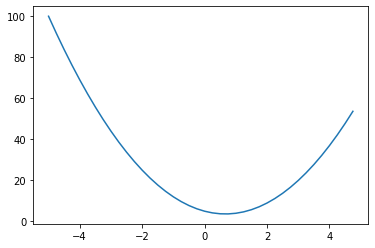

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [7]:
h = 0.00000000001
x = 2/3
(f(x+h)-f(x))/h ###derivative or slope

0.0

In [8]:
a = 2.0
b =-3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001
a = 2.0
b =-3.0
c = 10.0
d1 = a*b + c
a += h

d2= a*b+c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [6]:
class Value:
    
    def __init__(self,data, _children=(),_op='',label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None
    def __repr__(self):
        return f"Value(data)={self.data}"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)   
        out = Value(self.data + other.data,(self,other),'+')
        
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)   
        out = Value(self.data * other.data, (self,other),'*')
        
        def _backward():
            self.grad += other.data* out.grad 
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
        
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other-1) ## d/dx x^y = y*x^(y-1)
        out._backward = _backward
        
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        
        out._backward = _backward
            
        return out
    
    def backward(self):
       
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [67]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c  =Value(10.0,label='c')
e = a*b;e.label='e'

d = e + c ; d.label='d'
f = Value(-2.0,label='f')
L = d * f; L.label = 'L'

In [37]:
d._prev

{Value(data)=-6.0, Value(data)=10.0}

In [40]:
d._op

'+'

In [7]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={"rankdir":"LR"})
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value create a rectangular node
        dot.node(name=uid,label="{%s | data %.4f | grad %.4f}"%(n.label,n.data,n.grad),shape="record")
        
        if n._op:###fake operation nodes
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
            
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

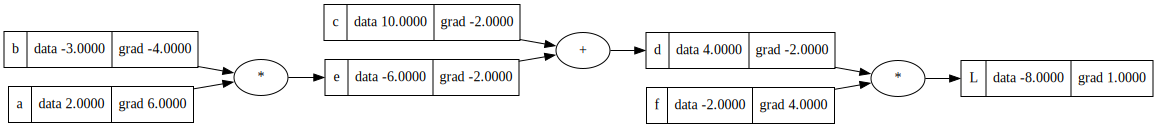

In [79]:
draw_dot(L)

In [78]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [80]:
a.data +=0.01*a.grad
b.data +=0.01*b.grad
c.data +=0.01*c.grad
f.data +=0.01*f.grad

e = a*b
d = e + c 
L = d * f

print(L.data)

-7.286496


In [77]:
def test_code():
    
    h = 0.001
    
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c  =Value(10.0,label='c')
    e = a*b;e.label='e'

    d = e + c ; d.label='d'
    f = Value(-2.0,label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c  =Value(10.0,label='c')
    e = a*b;e.label='e'
    e.data += h

    d = e + c ; d.label='d'
   
    f = Value(-2.0,label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
    
test_code()

-2.000000000000668


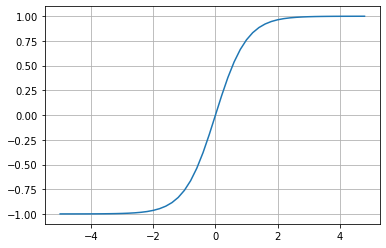

In [83]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid()

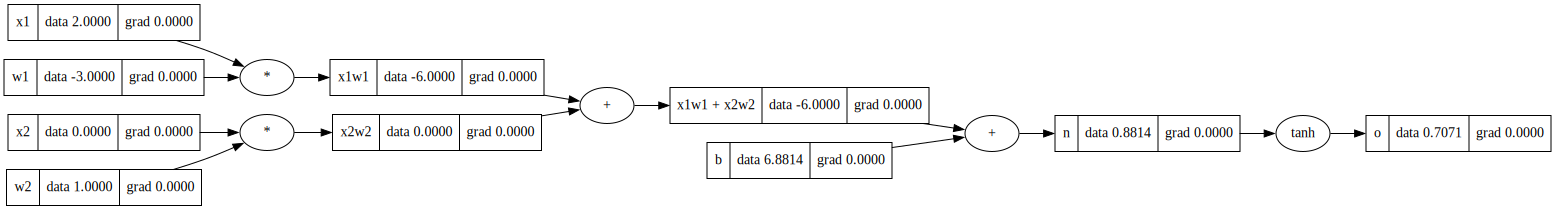

In [97]:
#input x1,x2

x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias
b = Value(6.88137358701,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh();o.label = 'o'
draw_dot(o)


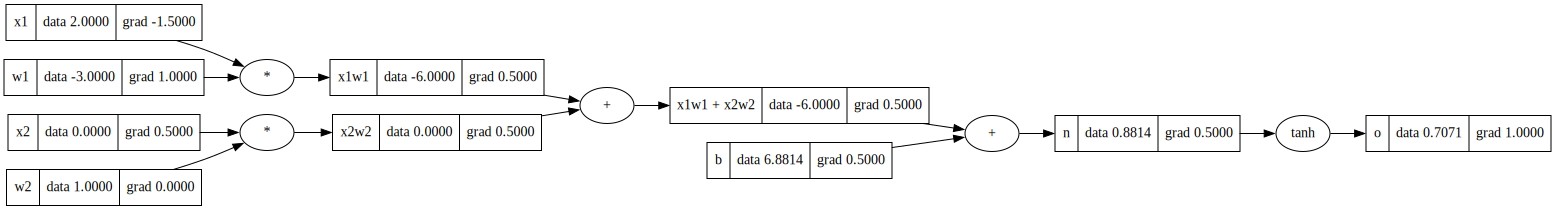

In [103]:
draw_dot(o)

In [98]:
o.grad = 1.0
o._backward()

In [99]:
n._backward()

In [100]:
x1w1x2w2._backward()

In [101]:
b._backward()

In [102]:
x1w1._backward()
x2w2._backward()

In [88]:
o.grad = 1.0

##n.grad = 1 - tanh**2 = 1 - o**2
n.grad = 0.6347



In [89]:
x1w1x2w2.grad = 0.6347
b.grad = 0.6347


In [90]:
x1w1.grad = 0.6347
x2w2.grad = 0.6347

In [91]:
x1.grad = -3.0 * 0.6347
w1.grad = 2.0 * 0.6347
x2.grad = 1.0 * 0.6347
w2.grad = 0.0

In [115]:
a = Value(2.0)
a + 2

Value(data)=4.0

In [112]:
a * 2

Value(data)=4.0

In [120]:
a = Value(2.0)
a.exp()

Value(data)=7.38905609893065

In [128]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data)=-2.0

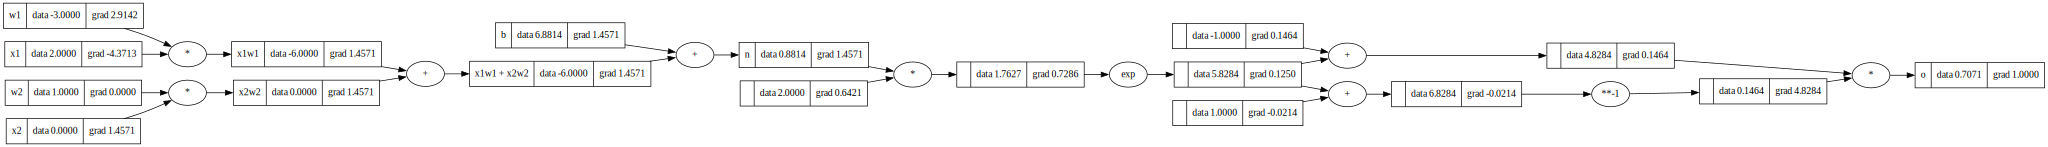

In [130]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias
b = Value(6.88137358701,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()

o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [2]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.88]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2',x2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())


0.7064193777288968
x2 0.5009716627691181
x1 -1.5029149883073543
w1 1.0019433255382362
w2 0.0


In [3]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

## MLP

In [8]:
import random

class Neuron:
    
    def __init__(self,nin):
            
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act =  sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    

In [9]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data)=0.4510729685805998

In [14]:
n.parameters()

[Value(data)=-0.3330767009897031,
 Value(data)=0.7165637889080085,
 Value(data)=-0.6327336055551529,
 Value(data)=0.34852906101146264,
 Value(data)=0.09164241995819111,
 Value(data)=0.8778821518097135,
 Value(data)=-0.3826723494933535,
 Value(data)=0.027774121917830685,
 Value(data)=0.07279034171267718,
 Value(data)=-0.5577679700879856,
 Value(data)=-0.14142157293853885,
 Value(data)=0.818190120630262,
 Value(data)=-0.5995069506616297,
 Value(data)=-0.5328898531149286,
 Value(data)=0.23270968226979116,
 Value(data)=-0.6037745584221763,
 Value(data)=-0.7555053322261853,
 Value(data)=-0.05832135511171099,
 Value(data)=-0.22796521508101253,
 Value(data)=0.1393852169099239,
 Value(data)=-0.8444068415161765,
 Value(data)=0.6248693865798158,
 Value(data)=-0.974521293671671,
 Value(data)=-0.8331382760933528,
 Value(data)=0.2007813697143288,
 Value(data)=0.20403727123693027,
 Value(data)=-0.70008764431488,
 Value(data)=-0.15882990019109022,
 Value(data)=-0.34478630048899794,
 Value(data)=0.653

In [31]:
xs = [[2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]]

ys = [1.0,-1.0,-1.0,1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data)=-2.8368844415764094e-06,
 Value(data)=-0.9197785941983829,
 Value(data)=-0.8568308056379893,
 Value(data)=4.702168392478269e-06]

In [17]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data)=6.517052882846785

In [18]:
loss.backward()

In [19]:
n.layers[0].neurons[0].w[0].grad

-5.427986969445591

In [20]:
n.layers[0].neurons[0].w[0].data

-0.3330767009897031

In [21]:
n.parameters()

[Value(data)=-0.3330767009897031,
 Value(data)=0.7165637889080085,
 Value(data)=-0.6327336055551529,
 Value(data)=0.34852906101146264,
 Value(data)=0.09164241995819111,
 Value(data)=0.8778821518097135,
 Value(data)=-0.3826723494933535,
 Value(data)=0.027774121917830685,
 Value(data)=0.07279034171267718,
 Value(data)=-0.5577679700879856,
 Value(data)=-0.14142157293853885,
 Value(data)=0.818190120630262,
 Value(data)=-0.5995069506616297,
 Value(data)=-0.5328898531149286,
 Value(data)=0.23270968226979116,
 Value(data)=-0.6037745584221763,
 Value(data)=-0.7555053322261853,
 Value(data)=-0.05832135511171099,
 Value(data)=-0.22796521508101253,
 Value(data)=0.1393852169099239,
 Value(data)=-0.8444068415161765,
 Value(data)=0.6248693865798158,
 Value(data)=-0.974521293671671,
 Value(data)=-0.8331382760933528,
 Value(data)=0.2007813697143288,
 Value(data)=0.20403727123693027,
 Value(data)=-0.70008764431488,
 Value(data)=-0.15882990019109022,
 Value(data)=-0.34478630048899794,
 Value(data)=0.653

In [22]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [23]:
ypred

[Value(data)=0.4510729685805998,
 Value(data)=0.738178263783875,
 Value(data)=0.51946170985317,
 Value(data)=0.05888128664699019]

In [32]:
for k in range(20):
    
    #forward pass
    ypred = [n(x) for s in xs]
    
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    #backward pass:
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update w and b
    for p in n.parameters():
        p.data += -0.5 * p.grad
        
    print(k , loss.data)

0 4.000000000032192
1 4.000000009529241
2 4.000002820799841
3 4.000834911240755
4 4.237057449074909
5 7.9932272978712415
6 7.992803278959331
7 7.992323915496282
8 7.991777779511899
9 7.991150101863498
10 7.990421467688199
11 7.989565854812076
12 7.988547597311591
13 7.987316525341613
14 7.985799876572235
15 7.98388820078058
16 7.981409403750039
17 7.978077619950573
18 7.973383660374437
19 7.966333409758342


In [26]:
ypred

[Value(data)=-0.6078178607743465,
 Value(data)=-0.6078178607743465,
 Value(data)=-0.6078178607743465,
 Value(data)=-0.6078178607743465]